In [1]:
import pickle
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from neuralhydrology.evaluation import metrics

In [2]:
from typing import Dict

from torch.utils.data import DataLoader

from neuralhydrology.datasetzoo import get_dataset, camelsus
from neuralhydrology.evaluation.utils import load_scaler
from neuralhydrology.modelzoo.cudalstm import CudaLSTM
from neuralhydrology.modelzoo.customlstm import CustomLSTM
from neuralhydrology.nh_run import start_run
from neuralhydrology.utils.config import Config

In [3]:
config_file = Path('config.yml')
run_dir = Path("runs/Cantabrico_1808_095102")

### Modelo

In [4]:
cudalstm_config = Config(config_file)

# create a new model instance with random weights
cuda_lstm = CudaLSTM(cfg=cudalstm_config)

# load the trained weights into the new model.
model_path = run_dir / 'model_epoch030.pt'
model_weights = torch.load(str(model_path), map_location='cpu')  # load the weights from the file, creating the weight tensors on CPU
cuda_lstm.load_state_dict(model_weights)  # set the new model's weights to the values loaded from file
cuda_lstm

CudaLSTM(
  (embedding_net): InputLayer(
    (statics_embedding): Identity()
    (dynamics_embedding): Identity()
  )
  (lstm): LSTM(29, 128)
  (dropout): Dropout(p=0.4, inplace=False)
  (head): Regression(
    (net): Sequential(
      (0): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

In [5]:
custom_lstm = CustomLSTM(cfg=cudalstm_config)  # create a new CustomLSTM (with random weights)
custom_lstm.copy_weights(cuda_lstm)  # copy the CudaLSTM weights into the CustomLSTM
custom_lstm

CustomLSTM(
  (embedding_net): InputLayer(
    (statics_embedding): Identity()
    (dynamics_embedding): Identity()
  )
  (cell): _LSTMCell()
  (dropout): Dropout(p=0.4, inplace=False)
  (head): Regression(
    (net): Sequential(
      (0): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

In [6]:
torch.allclose(cuda_lstm.lstm.bias_ih_l0, custom_lstm.cell.b_ih)

True

In [7]:
# make sure we're in eval mode where dropout is deactivated
custom_lstm.eval()
cuda_lstm.eval()

# load the dataset
scaler = load_scaler(run_dir)
dataset = get_dataset(cudalstm_config, is_train=False, period='test', scaler=scaler)
dataloader = DataLoader(dataset, batch_size=1000, shuffle=False, collate_fn=dataset.collate_fn)

cudalstm_output = []
customlstm_output = []
# no need to calculate any gradients since we're just running some evaluations
with torch.no_grad():
    for sample in dataloader:
        customlstm_output.append(custom_lstm(sample))
        cudalstm_output.append(cuda_lstm(sample))

print('CudaLSTM output:  ', list(cudalstm_output[0].keys()))
print('CustomLSTM output:', list(customlstm_output[0].keys()))

# check if predictions of CustomLSTM and CudaLSTM are identical
print('Identical predictions:', torch.allclose(customlstm_output[0]['y_hat'], cudalstm_output[0]['y_hat'], atol=1e-5))

CudaLSTM output:   ['lstm_output', 'h_n', 'c_n', 'y_hat']
CustomLSTM output: ['h_n', 'c_n', 'i', 'f', 'g', 'o', 'y_hat']
Identical predictions: False


In [9]:
print('CudaLSTM shape:  ', cudalstm_output[0]['c_n'].shape)  # [batch size, 1, hidden size]
print('CustomLSTM shape:', customlstm_output[0]['c_n'].shape)  # [batch size, sequence length, hidden size]

CudaLSTM shape:   torch.Size([1000, 1, 128])
CustomLSTM shape: torch.Size([1000, 365, 128])


In [10]:
print('CudaLSTM shape:  ', cudalstm_output[1]['c_n'].shape)  # [batch size, 1, hidden size]
print('CustomLSTM shape:', customlstm_output[1]['c_n'].shape)  # [batch size, sequence length, hidden size]

CudaLSTM shape:   torch.Size([1000, 1, 128])
CustomLSTM shape: torch.Size([1000, 365, 128])


In [8]:
len(customlstm_output)

14

In [11]:
# Concatenate all batches into one tensor that contains the final time step of each sample.
cell_states = torch.cat([out['c_n'][:, -1, :] for out in customlstm_output], dim=0)

# Load the forcings input for the corresponding date range
date_range = pd.date_range(cudalstm_config.test_start_date, cudalstm_config.test_end_date, freq='1D')

ValueError: test_start_date is not specified in the config (.yml).

In [ ]:
forcings = camelsus.load_camels_us_forcings(cudalstm_config.data_dir, '01022500', 'daymet')[0].loc[date_range]

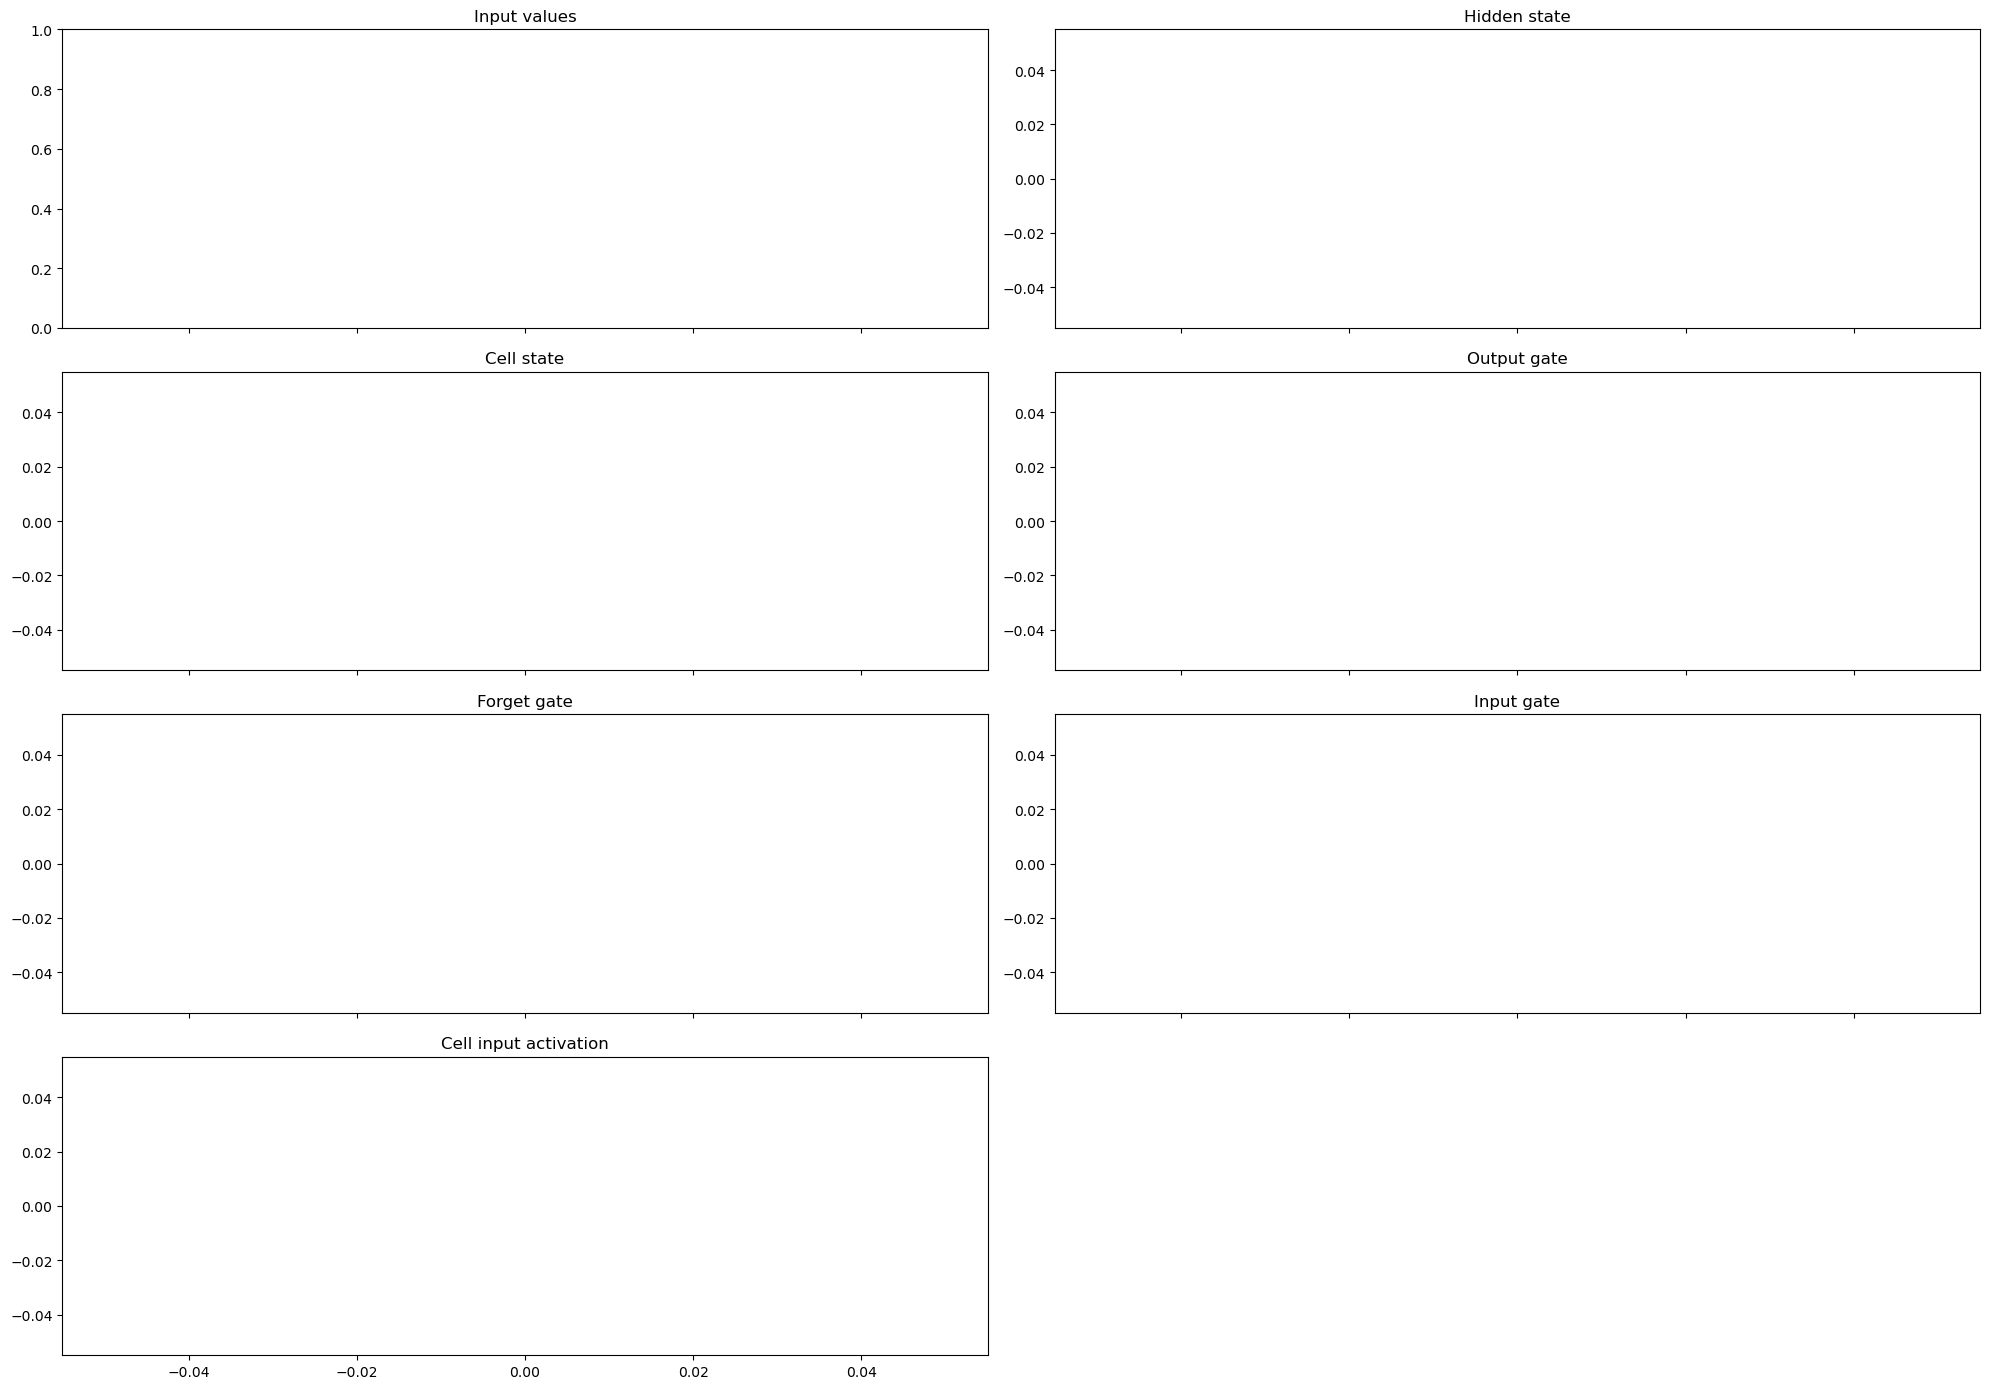

In [42]:
f, ax = plt.subplots(4, 2, figsize=(20, 14), sharex=True)
ax[0,0].set_title('Input values')
#lines = ax[0,0].plot(dataset[0]['x_d'])  # these are the normalized inputs we fed the LSTM above
#ax[0,0].legend(lines, cudalstm_config.dynamic_inputs, frameon=False)

ax[1,0].set_title('Cell state')
ax[1,0].plot(customlstm_output[0]['c_n'][0])

ax[0,1].set_title('Hidden state')
ax[0,1].plot(customlstm_output[0]['h_n'][0])

ax[1,1].set_title('Output gate')
ax[1,1].plot(customlstm_output[0]['o'][0])

ax[2,0].set_title('Forget gate')
ax[2,0].plot(customlstm_output[0]['f'][0])

ax[2,1].set_title('Input gate')
ax[2,1].plot(customlstm_output[0]['i'][0])

ax[3,0].set_title('Cell input activation')
ax[3,0].plot(customlstm_output[0]['g'][0])

f.delaxes(ax[3,1])
plt.tight_layout()

***

In [3]:
model = torch.load(run_dir / 'model_epoch030.pt', map_location=torch.device('cpu'))

if torch.cuda.is_available():
    model = model.to('cuda')

In [5]:
model.keys()

odict_keys(['lstm.weight_ih_l0', 'lstm.weight_hh_l0', 'lstm.bias_ih_l0', 'lstm.bias_hh_l0', 'head.net.0.weight', 'head.net.0.bias'])

In [10]:
for key in model.keys():
    print(key, model[key].shape, sep='\t')

lstm.weight_ih_l0	torch.Size([512, 29])
lstm.weight_hh_l0	torch.Size([512, 128])
lstm.bias_ih_l0	torch.Size([512])
lstm.bias_hh_l0	torch.Size([512])
head.net.0.weight	torch.Size([1, 128])
head.net.0.bias	torch.Size([1])


### Optimizador

In [11]:
optimizer = torch.load(run_dir / 'optimizer_state_epoch030.pt', map_location=torch.device('cpu'))

In [12]:
optimizer.keys()

dict_keys(['state', 'param_groups'])

In [15]:
optimizer['state']

{0: {'step': tensor(6960.),
  'exp_avg': tensor([[ 9.0062e-08, -2.0210e-07, -2.2574e-07,  ...,  3.2497e-07,
            3.6161e-07, -7.0539e-07],
          [-4.7444e-09, -3.2513e-09, -1.2327e-09,  ..., -5.0478e-09,
           -1.0374e-09,  4.5407e-09],
          [-9.5753e-08, -8.2562e-09,  3.0173e-09,  ...,  2.5874e-08,
            3.5104e-08, -5.3518e-08],
          ...,
          [ 1.1354e-06, -2.4460e-07, -6.1073e-07,  ..., -4.9660e-07,
           -1.5411e-07, -1.6017e-07],
          [-1.1742e-08, -5.5606e-08, -6.8281e-09,  ...,  2.2427e-08,
            1.4428e-07, -7.4157e-09],
          [ 1.5283e-06, -1.0814e-07, -3.0446e-07,  ..., -1.3340e-07,
           -3.3442e-08,  3.1851e-07]]),
  'exp_avg_sq': tensor([[3.4233e-11, 1.2968e-12, 2.6395e-12,  ..., 1.0800e-12, 1.5310e-12,
           2.2989e-12],
          [1.0376e-15, 5.1534e-16, 6.4916e-16,  ..., 2.5449e-15, 3.3568e-15,
           3.2273e-15],
          [4.3818e-13, 8.3720e-15, 1.4194e-14,  ..., 3.7206e-14, 2.8073e-14,
         